# Natural Language Processing - Consumer Complaint in bank sector

## Research question: 

* How to develop an automatic text classification model that assigns customer complaints to the correct product categories based on their content?

Authors: Alam Jasia, Hubweber Michaela, Schumich Kathrin, Ye Florian

Dataset: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from IPython.display import display
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from scipy import stats
from textblob import TextBlob
from spacy.cli import download
from sklearn.preprocessing import LabelEncoder  # For encoding labels

import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer
import zipfile

from gensim.models import Word2Vec
from narrative_to_vec import tokenize_column, add_column_average_genre_vector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Download the language model
try:
    # Try to load the language model
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model loaded successfully.")
except OSError:
    # If the model is not available, download it using spacy.cli.download
    print("Model not found. Downloading...")
    download("en_core_web_sm")
    
    # After downloading, try loading again
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model downloaded and loaded successfully.")

## 3 Feature Engineering

In [ ]:
# Read the small dataset
data_path = os.path.join("data", "small.zip")
data = pd.read_csv(data_path)

In [23]:
# Lemmatize text 
### MAY TAKE A WHILE TO RUN ###
### Depending on system, changing batch size could speed up the process (I think :) )
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in spacy_nlp.pipe(data["narrative_prep"], batch_size=1000, n_process=-1): # runs in parallel (cpu)
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
data["text_lemma"] = lemma_text_list

In [24]:
data['word_count'] = data['narrative'].apply(lambda x: len(x.split()))
data['char_count'] = data['narrative'].apply(lambda x: len(x))
data['sentence_count'] = data['narrative'].apply(lambda x: len(x.split('.')))

data[['narrative', 'word_count', 'char_count', 'sentence_count']].head()

,narrative,word_count,char_count,sentence_count
0,used third party company book vacation package...,64,485,1
1,company u bank reliacard issue account locked ...,66,421,1
2,victim identity fraud personal financial infor...,91,696,1
3,browsing online site invited apply credit card...,70,496,1
4,made payment credit card balance resulting cre...,20,143,1


 ### TF-IDF
Extracting key text features using TF-IDF

In [25]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data['narrative_prep'])

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
display(tfidf_df.head())

,account,bank,called,card,company,credit,day,debt,information,letter,loan,money,month,payment,received,report,said,sent,time,told
0,0.000000,0.371500,0.000000,0.000000,0.904632,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.208876,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.228969,0.515305,0.000000,0.000000,0.167308,0.000000,0.168152,0.0,0.172351,0.0,0.0,0.193154,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.747498,0.000000
2,0.117642,0.706022,0.177973,0.369959,0.000000,0.377729,0.000000,0.0,0.354209,0.0,0.0,0.000000,0.0,0.000000,0.0,0.165549,0.0,0.000000,0.153623,0.000000
3,0.000000,0.232403,0.000000,0.852465,0.000000,0.414461,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.217977,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.598907,0.000000,0.407657,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.549107,0.0,0.000000,0.0,0.298447,0.000000,0.290754


In [26]:
tfidf_df

,account,bank,called,card,company,credit,day,debt,information,letter,loan,money,month,payment,received,report,said,sent,time,told
0,0.000000,0.371500,0.000000,0.000000,0.904632,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.208876,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.228969,0.515305,0.000000,0.000000,0.167308,0.000000,0.168152,0.0,0.172351,0.0,0.0,0.193154,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.747498,0.000000
2,0.117642,0.706022,0.177973,0.369959,0.000000,0.377729,0.000000,0.0,0.354209,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.165549,0.000000,0.000000,0.153623,0.000000
3,0.000000,0.232403,0.000000,0.852465,0.000000,0.414461,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.217977,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.598907,0.000000,0.407657,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.549107,0.0000,0.000000,0.000000,0.298447,0.000000,0.290754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67170,0.441271,0.000000,0.667573,0.000000,0.214958,0.000000,0.432086,0.0,0.000000,0.0,0.0,0.248165,0.0,0.000000,0.0000,0.000000,0.255216,0.000000,0.000000,0.000000
67171,0.000000,0.368541,0.743213,0.000000,0.000000,0.000000,0.360783,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.426201,0.000000,0.000000,0.000000
67172,0.504037,0.000000,0.000000,0.000000,0.000000,0.000000,0.370160,0.0,0.000000,0.0,0.0,0.425197,0.0,0.000000,0.3523,0.000000,0.000000,0.394942,0.000000,0.384761
67173,0.833373,0.312591,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.326498,0.000000,0.318081


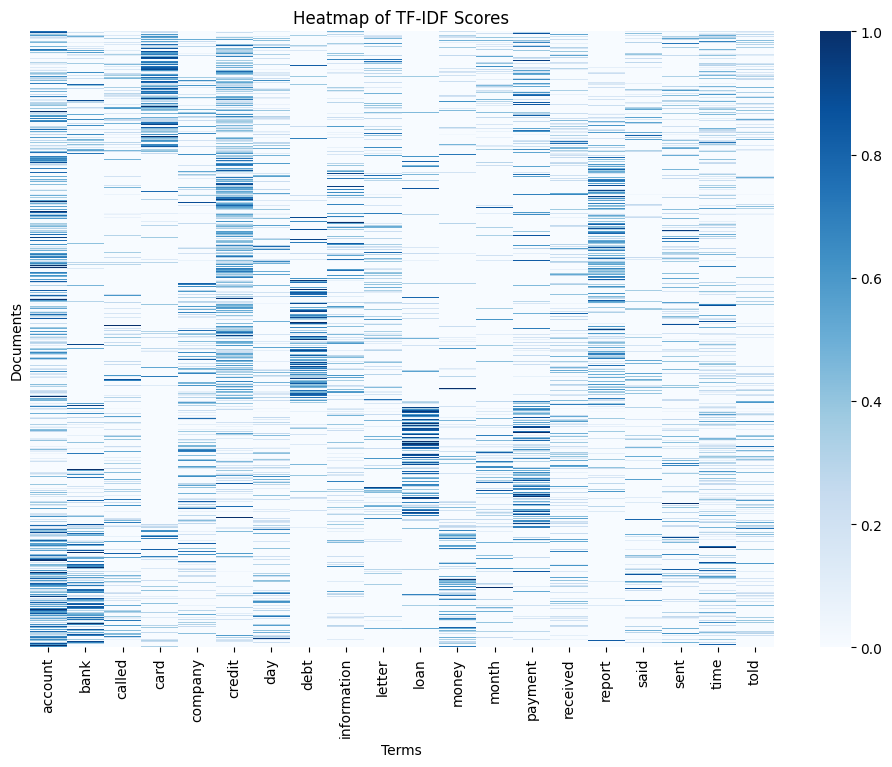

In [27]:
# Plot a heatmap of the TF-IDF matrix
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df, cmap='Blues', yticklabels=False)
plt.title('Heatmap of TF-IDF Scores')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

The heatmap shows how the TF-IDF scores are distributed across different narratives (documents).

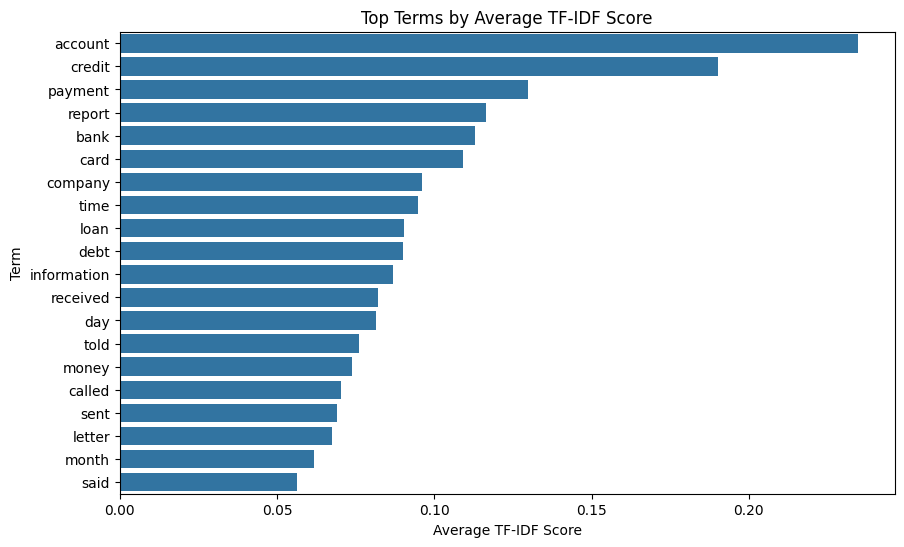

In [28]:
# Get the average TF-IDF score for each term across all documents
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Plot the top terms by average TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index)
plt.title('Top Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

#### Top words by TF-IDF score by products:

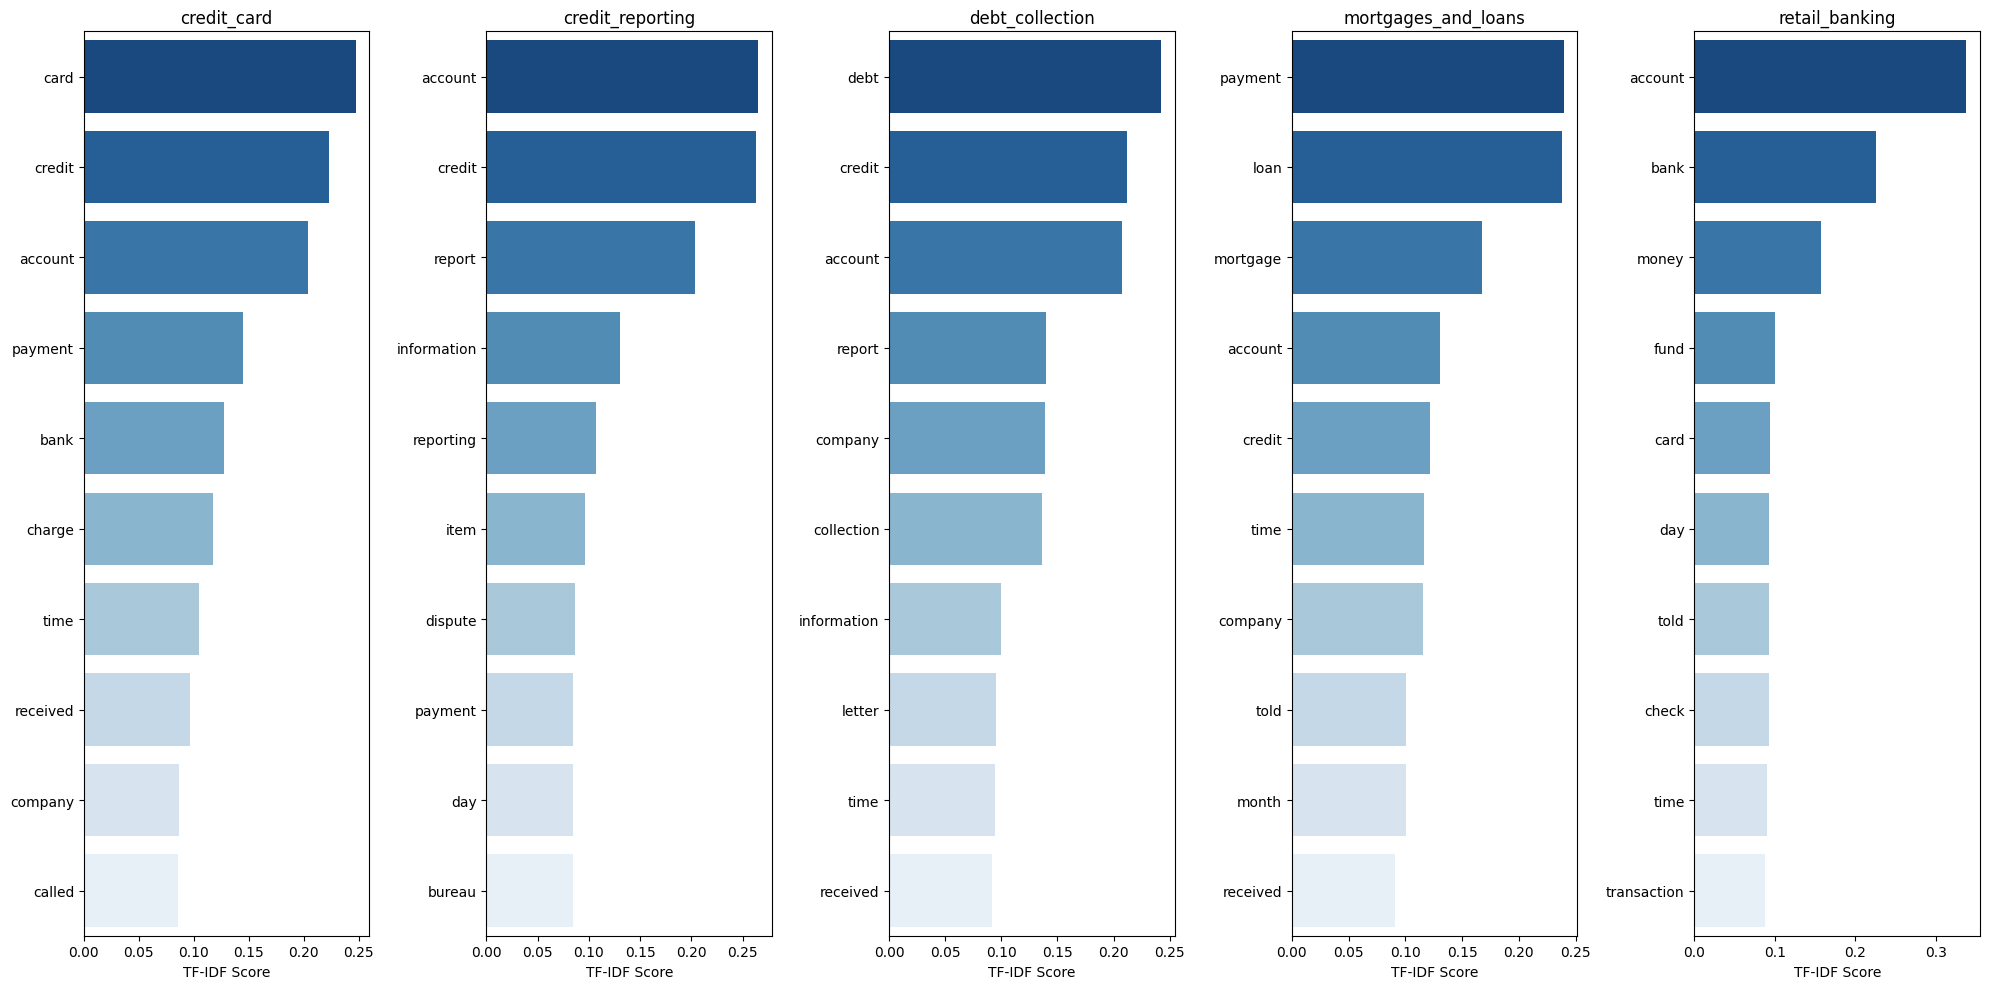

In [29]:
products = data['product'].unique()

# Initialize a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=20)

# Create a figure with a 2x5 grid of subplots (adjust the number of rows and columns based on your product count)
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten to easily index subplots

# Iterate through each product and its corresponding subplot
for i, product in enumerate(products):
    # Filter the data for the current product
    product_data = data[data['product'] == product]
    
    # Apply TF-IDF on the 'narrative_prep' column for the current product
    tfidf_matrix = tfidf.fit_transform(product_data['narrative_prep'])
    
    # Create a DataFrame with the TF-IDF scores for each term
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    
    # Compute the average TF-IDF score for each term
    tfidf_mean = tfidf_df.mean().sort_values(ascending=False)
    
    # Take the top 10 terms with the highest TF-IDF scores
    top_words = tfidf_mean.head(10)
    
    # Plot the top words for this product in its corresponding subplot
    sns.barplot(x=top_words.values, y=top_words.index, ax=axes[i], palette = 'Blues_r')
    axes[i].set_title(f'{product}')
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_ylabel('')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#### Sentiment-Analyse: 
Conducting sentiment analysis to find out whether the text is negative, neutral or positive.

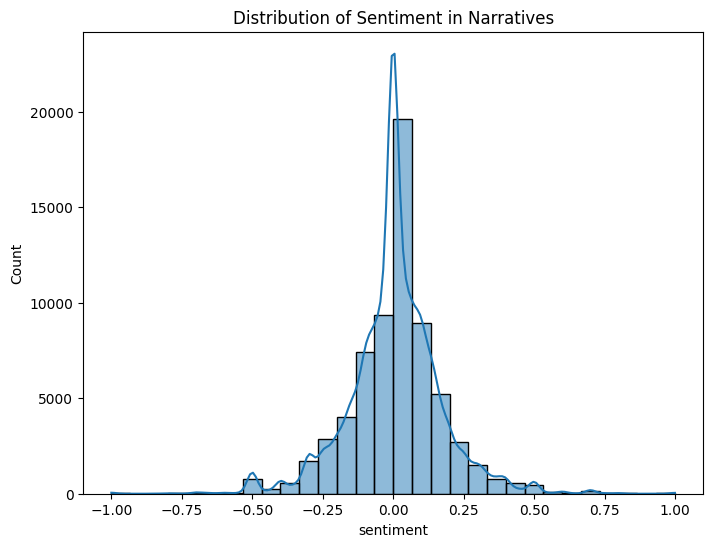

In [30]:
data['sentiment'] = data['narrative_prep'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8,6))
sns.histplot(data['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment in Narratives')
plt.show()

The calculated sentiment score ranges from -1 (negative), to 0 (neutral) and 1 (positive).

#### Sentiment-Analyse by products:

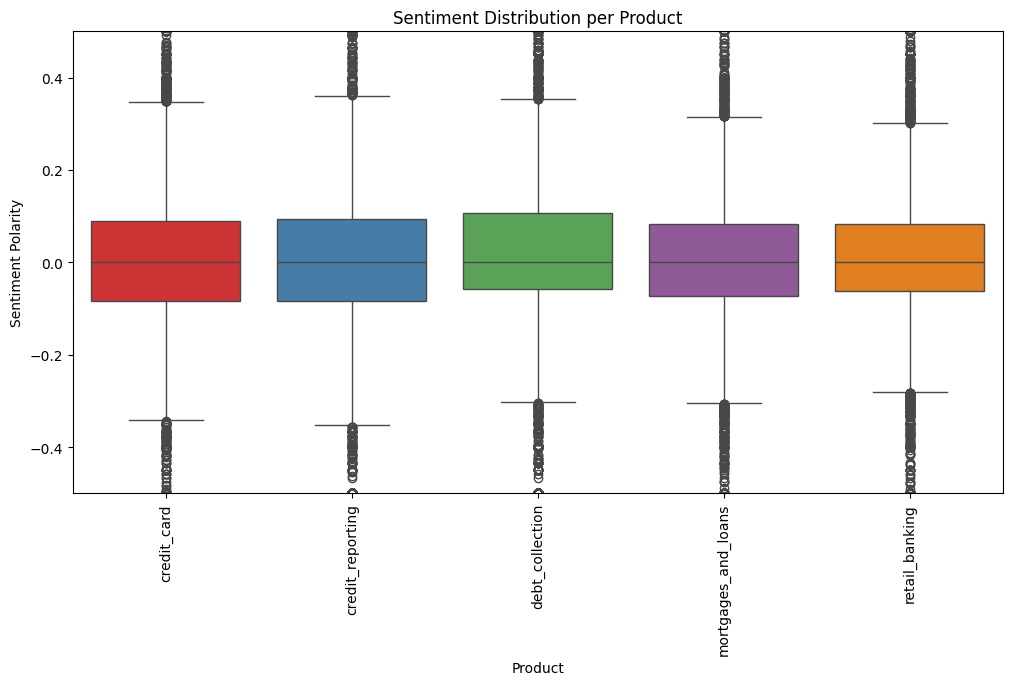

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='product', y='sentiment', palette='Set1')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.title('Sentiment Distribution per Product')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Product')
plt.show()

In [32]:
data.to_csv('data/small_data_eda.zip', index=False, compression='zip')